Read CSV data with Pandas.

In [50]:
import pandas as pd
import numpy as np

# team stats
team_summaries = pd.read_csv('nba_data/stats_archive/Team Summaries.csv')
# team_totals = pd.read_csv('nba_data/stats_archive/Team Totals.csv')
team_per100 = pd.read_csv('nba_data/stats_archive/Team Stats Per 100 Poss.csv')

# player stats
# player_totals = pd.read_csv('nba_data/stats_archive/Player Totals.csv')
player_shooting = pd.read_csv('nba_data/stats_archive/Player Shooting.csv')
player_play_by_play = pd.read_csv('nba_data/stats_archive/Player Play By Play.csv')
player_per100 = pd.read_csv('nba_data/stats_archive/Per 100 Poss.csv')

# games
games = pd.read_csv('nba_data/game_archive/games.csv')
teamids = pd.read_csv('nba_data/game_archive/teams.csv')


Remove unnecessary features.

In [2]:
# games
teamids['TEAM_NAME'] = teamids['CITY'] + ' ' + teamids['NICKNAME']
teamids = teamids[['TEAM_ID','TEAM_NAME','ABBREVIATION']]

games = games[['GAME_DATE_EST','GAME_ID','HOME_TEAM_ID','VISITOR_TEAM_ID','SEASON','HOME_TEAM_WINS','PTS_home','PTS_away']]

In [3]:
# team stats
team_stats = team_summaries.merge(team_per100)
team_stats.drop(columns=['playoffs','arena','attend','lg'], inplace=True)

# player stats
player_stats = player_shooting.merge(player_play_by_play).merge(player_per100)
player_stats.drop(columns=['birth_year','pos','lg'], inplace=True)

Create player efficiency indices.

𝐼NBA=𝑁pts+𝑁rbs+𝑁asts+𝑁stls+𝑁blcks−(𝑁msFld+𝑁msFT+𝑁tos)

In [4]:
player_stats['player_eff_ind'] = (player_stats['pts_per_100_poss'] +
                           player_stats['trb_per_100_poss'] +
                           player_stats['ast_per_100_poss'] +
                           player_stats['stl_per_100_poss'] +
                           player_stats['blk_per_100_poss'] -
                           (player_stats['tov_per_100_poss'] +
                            player_stats['fga_per_100_poss'] - player_stats['fg_per_100_poss'] +
                            player_stats['fta_per_100_poss'] - player_stats['ft_per_100_poss']))
# player_stats

Create team efficiency indices.

In [5]:
#create the team efficeny index by summing the players by season and team 
team_eff_ind = player_stats.groupby(['tm', 'season'])['player_eff_ind'].sum().reset_index(name='team_eff_ind')
team_eff_ind.rename(columns = {'tm':'abbreviation'}, inplace = True)

In [6]:
#merging the team efficeny index to team_stats
team_stats = team_stats.merge(team_eff_ind)
# team_stats

To each game, append home and away team stats in the respective season.

In [7]:
# add team_id to team stats
teamids.rename(columns = {'ABBREVIATION':'abbreviation','TEAM_NAME':'team'}, inplace = True)
team_stats = team_stats.merge(teamids)
team_stats.drop(columns=['team','abbreviation'], inplace = True)

In [8]:
min(team_stats.season)

1997

In [9]:
# add home team stats to games
h_team_stats = team_stats.add_prefix('h_')
final_df = games.merge(h_team_stats, left_on=['HOME_TEAM_ID','SEASON'], right_on=['h_TEAM_ID','h_season'])
final_df.drop(columns=['h_season','h_TEAM_ID'], inplace = True)

# add away team stats to games
a_team_stats = team_stats.add_prefix('a_')
final_df = final_df.merge(a_team_stats, left_on=['VISITOR_TEAM_ID','SEASON'], right_on=['a_TEAM_ID','a_season'])
final_df.drop(columns=['a_season','a_TEAM_ID'], inplace = True)

In [10]:
# sort games by date, ascending
final_df['GAME_DATE_EST'] = pd.to_datetime(final_df['GAME_DATE_EST'])
final_df = final_df.sort_values(by='GAME_DATE_EST', ascending=True).reset_index(drop=True)

Add novel features from the parent paper.

In [11]:
import warnings
warnings.filterwarnings("ignore")

final_df = final_df[final_df['HOME_TEAM_WINS'].notna()]

def get_avg_win_pct_last_n_games(team, game_date, df, n):
    # Extract the last 10 games 
    prev_game_df = df[df['GAME_DATE_EST'] < game_date][(df['HOME_TEAM_ID'] == team) | (df['VISITOR_TEAM_ID'] == team)].tail(n)
    
    wins = 0 
    # Filter columns to include only 'Home' team and result, then divide into home and away games        
    result_df = prev_game_df
    h_df = result_df.loc[result_df['HOME_TEAM_ID'] == team] 
    
    h_wins = h_df.loc[h_df['HOME_TEAM_WINS'] == 1]
    
    wins += len(h_wins)
    
    a_df = result_df.loc[result_df['HOME_TEAM_ID'] != team]
    a_wins = a_df.loc[a_df['HOME_TEAM_WINS'] == 0]
    
    wins += len(a_wins)

    return wins/n

for index, row in final_df.iterrows() : 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    h_team = row['HOME_TEAM_ID']
    a_team = row['VISITOR_TEAM_ID']
    final_df.loc[index,'H_w_pct_10'] = get_avg_win_pct_last_n_games(h_team, game_date, final_df, 10)
    final_df.loc[index,'A_w_pct_10'] = get_avg_win_pct_last_n_games(a_team, game_date, final_df, 10)

# final_df.head(20)

In [12]:
# Home and road team win probabilities implied by Elo ratings and home court adjustment 
import math
# import time

final_df = final_df[final_df['PTS_away'].notna() & final_df['PTS_home'].notna()]

# Calculate win probabilities using Elo ratings and home court advantage
def win_probs(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400) 

    denom = r + a*h
    home_prob = a*h / denom
    away_prob = r / denom 
  
    return home_prob, away_prob

# Calculate odds of the home team winning based on Elo ratings and home court advantage
def home_odds_on(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400)
    return a*h/r

# Determines the K factor in Elo rating updates, considering the margin of victory and Elo rating difference
def elo_k(MOV, elo_diff):
    k = 20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier

# Update Elo ratings for both teams following a game, considering the outcome and game specifics
def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
    home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

    if (home_score - away_score > 0) :
        home_win = 1 
        away_win = 0 
    else :
        home_win = 0 
        away_win = 1 
  
    k = elo_k(home_score - away_score, home_elo - away_elo)

    updated_home_elo = home_elo + k * (home_win - home_prob) 
    updated_away_elo = away_elo + k * (away_win - away_prob)
    
    return updated_home_elo, updated_away_elo

# Define a function to retrieve a team's Elo rating before a given game, adjusting for season transitions
def get_prev_elo(team, date, season, team_stats, elo_df) :
    prev_game = team_stats[team_stats['GAME_DATE_EST'] < date][(team_stats['HOME_TEAM_ID'] == team) | (team_stats['VISITOR_TEAM_ID'] == team)].tail(1).iloc[0] 

    if team == prev_game['HOME_TEAM_ID'] :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['H_Team_Elo_After'].values[0]
    else :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['A_Team_Elo_After'].values[0]
  
    if prev_game['SEASON'] != season :
        return (0.75 * elo_rating) + (0.25 * 1505)
    else :
        return elo_rating

# create elo feature
elo_df = pd.DataFrame(columns=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['GAME_ID','Team', 'Elo', 'GAME_DATE_EST', 'Where_Played', 'SEASON'])

# Loop through each game to update ELO ratings
for index, row in final_df.iterrows(): 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    season = row['SEASON']
    h_team, a_team = row['HOME_TEAM_ID'], row['VISITOR_TEAM_ID']
    h_score, a_score = row['PTS_home'], row['PTS_away'] 
    # Set or get previous Elo ratings
    if (h_team not in elo_df['HOME_TEAM_ID'].values and h_team not in elo_df['VISITOR_TEAM_ID'].values) :
        h_team_elo_before = 1500
    else :
        h_team_elo_before = get_prev_elo(h_team, game_date, season, final_df, elo_df)

    if (a_team not in elo_df['HOME_TEAM_ID'].values and a_team not in elo_df['VISITOR_TEAM_ID'].values) :
        a_team_elo_before = 1500
    else :
        a_team_elo_before = get_prev_elo(a_team, game_date, season, final_df, elo_df)

    h_team_elo_after, a_team_elo_after = update_elo(h_score, a_score, h_team_elo_before, a_team_elo_before, 69)

    new_row = {'GAME_ID': game_id, 'HOME_TEAM_ID': h_team, 'VISITOR_TEAM_ID': a_team, 'H_Team_Elo_Before': h_team_elo_before, 'A_Team_Elo_Before': a_team_elo_before, \
                                                                        'H_Team_Elo_After' : h_team_elo_after, 'A_Team_Elo_After': a_team_elo_after}
    teams_row_one = {'GAME_ID': game_id,'Team': h_team, 'Elo': h_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'HOME_TEAM_ID', 'SEASON': season}
    teams_row_two = {'GAME_ID': game_id,'Team': a_team, 'Elo': a_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'VISITOR_TEAM_ID', 'SEASON': season}
    
    # Record Elo ratings in elo_df and teams_elo_df
    elo_df.loc[len(elo_df)] = new_row
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_one
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_two

# dates = list(set([d.strftime("%m-%d-%Y") for d in teams_elo_df["GAME_DATE_EST"]]))
# dates = sorted(dates, key=lambda x: time.strptime(x, '%m-%d-%Y'))
# teams = final_df["VISITOR_TEAM_ID"]
# dataset = pd.DataFrame(columns=dates)
# dataset["Team"] = teams.drop_duplicates()
# dataset = dataset.set_index("Team")

# for index, row in teams_elo_df.iterrows():
#     # Create a dataset for tracking Elo ratings over time
#     date = row["GAME_DATE_EST"].strftime("%m-%d-%Y")
#     team = row["Team"]
#     elo = row["Elo"]
#     dataset[date][team] = elo

teams_elo_df['Elo'] = teams_elo_df['Elo'].astype(float)
# Merge updated Elo ratings back into the main DataFrame
final_df = final_df.merge(elo_df.drop(columns=['HOME_TEAM_ID', 'VISITOR_TEAM_ID']), on ='GAME_ID')

In [13]:
final_df.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON',
       'HOME_TEAM_WINS', 'PTS_home', 'PTS_away', 'h_age', 'h_w',
       ...
       'a_tov_per_100_poss', 'a_pf_per_100_poss', 'a_pts_per_100_poss',
       'a_team_eff_ind', 'H_w_pct_10', 'A_w_pct_10', 'H_Team_Elo_Before',
       'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'],
      dtype='object', length=110)

Reduce size of dataset to that of parent paper.

In [ ]:
# final_df = team_stats[(team_stats['season'] >= 2018) & (team_stats['season'] <= 2021)]
# final_df

Prepare data for feature reduction and machine learning.

In [34]:
X = final_df.drop(columns=['GAME_DATE_EST',
 'GAME_ID',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'HOME_TEAM_WINS',
 'H_Team_Elo_After',
 'A_Team_Elo_After'])

X = X.fillna(X.mean())

y = final_df['HOME_TEAM_WINS']

Exploratory data analysis.

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def eda(df):
    plt.figure(figsize=(25, 25))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True)
    plt.show()

# eda(final_df.drop(columns=['GAME_DATE_EST',
#  'GAME_ID',
#  'HOME_TEAM_ID',
#  'VISITOR_TEAM_ID',
#  'SEASON',
#  'H_Team_Elo_After',
#  'A_Team_Elo_After']))

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# noramlize data

# # Min-Max Scaling
# scaler_minmax = MinMaxScaler()
# df_minmax = pd.DataFrame(scaler_minmax.fit_transform(X), columns=X.columns)

# Standard Scaling
scaler_standard = StandardScaler()
X = pd.DataFrame(scaler_standard.fit_transform(X), columns=X.columns)

X, y = X.to_numpy(), y.to_numpy()

Perform feature reduction.

In [36]:
from sklearn.feature_selection import SelectKBest, f_classif

X_new = []
k = [5,10,100]

for ki in k:
    # Select top k features using SelectKBest and ANOVA F-value
    selector = SelectKBest(score_func=f_classif, k=ki)
    X_k = selector.fit_transform(X, y)
    X_new.append(X_k)

Apply machine learning algorithms to datasets.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report

def run_exps(X_train, X_test, y_train, y_test) :
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier()),
          ('MLP', MLPClassifier(max_iter=1000))]
    
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['win', 'loss']
    
    for name, model in models:
        
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # print(name)
        # print(classification_report(y_test, y_pred, target_names=target_names))
        
        results.append(cv_results)
        names.append(name)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    return pd.concat(dfs, ignore_index=True)

In [39]:
from sklearn.model_selection import train_test_split

results = []

for X in X_new:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    print(f'X train shape: {X_train.shape}')
    print(f'X test shape: {X_test.shape}')
    print(f'y train shape: {y_train.shape}')
    print(f'y test shape: {y_test.shape}')

    final = run_exps(X_train, X_test, y_train, y_test)
    results.append(final)

X train shape: (15189, 5)
X test shape: (5064, 5)
y train shape: (15189,)
y test shape: (5064,)
LogReg
              precision    recall  f1-score   support

         win       1.00      1.00      1.00      2076
        loss       1.00      1.00      1.00      2988

    accuracy                           1.00      5064
   macro avg       1.00      1.00      1.00      5064
weighted avg       1.00      1.00      1.00      5064

RF
              precision    recall  f1-score   support

         win       1.00      1.00      1.00      2076
        loss       1.00      1.00      1.00      2988

    accuracy                           1.00      5064
   macro avg       1.00      1.00      1.00      5064
weighted avg       1.00      1.00      1.00      5064

KNN
              precision    recall  f1-score   support

         win       0.97      0.96      0.97      2076
        loss       0.97      0.98      0.98      2988

    accuracy                           0.97      5064
   macro avg      

Inspect and visualize results.

In [44]:
results[0]

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.024349,0.004998,1.000000,1.000000,1.000000,1.000000,1.000000,LogReg
1,0.019999,0.004000,1.000000,1.000000,1.000000,1.000000,1.000000,LogReg
2,0.016000,0.004018,1.000000,1.000000,1.000000,1.000000,1.000000,LogReg
3,0.017008,0.003978,1.000000,1.000000,1.000000,1.000000,1.000000,LogReg
4,0.014997,0.004002,1.000000,1.000000,1.000000,1.000000,1.000000,LogReg
5,0.595672,0.055018,0.996379,0.996383,0.996379,0.996380,0.999965,RF
6,0.603568,0.055003,0.998354,0.998355,0.998354,0.998354,0.999981,RF
7,0.614712,0.054019,0.997038,0.997041,0.997038,0.997038,0.999963,RF
8,0.620813,0.058016,0.996708,0.996710,0.996708,0.996708,0.999928,RF
9,0.607888,0.054992,0.995719,0.995727,0.995719,0.995718,0.999943,RF


In [49]:
def evaluate_models(df):
    results_long = pd.melt(df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] # fit time metrics

    ## PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
    results_long_nofit = results_long_nofit.sort_values(by='values')

    ## TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
    results_long_fit = results_long_fit.sort_values(by='values')

    metrics = list(set(results_long_nofit.metrics.values))
    df.groupby(['model'])[metrics].agg([np.std, np.mean])

    return results_long_nofit, results_long_fit

    
def generate_plots(n_features, results_long_nofit, results_long_fit):    
    # generate plot comparing models' classification metrics
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(f'Comparison of Model by Classification Metric, {n_features} Features')
    plt.savefig('./benchmark_models_performance.png',dpi=300)
    plt.show()
    
    # generate plot comparing models' fit and score time
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(f'Comparison of Model by Fit and Score Time, {n_features} Features')
    plt.savefig('./benchmark_models_time.png',dpi=300)
    plt.show()

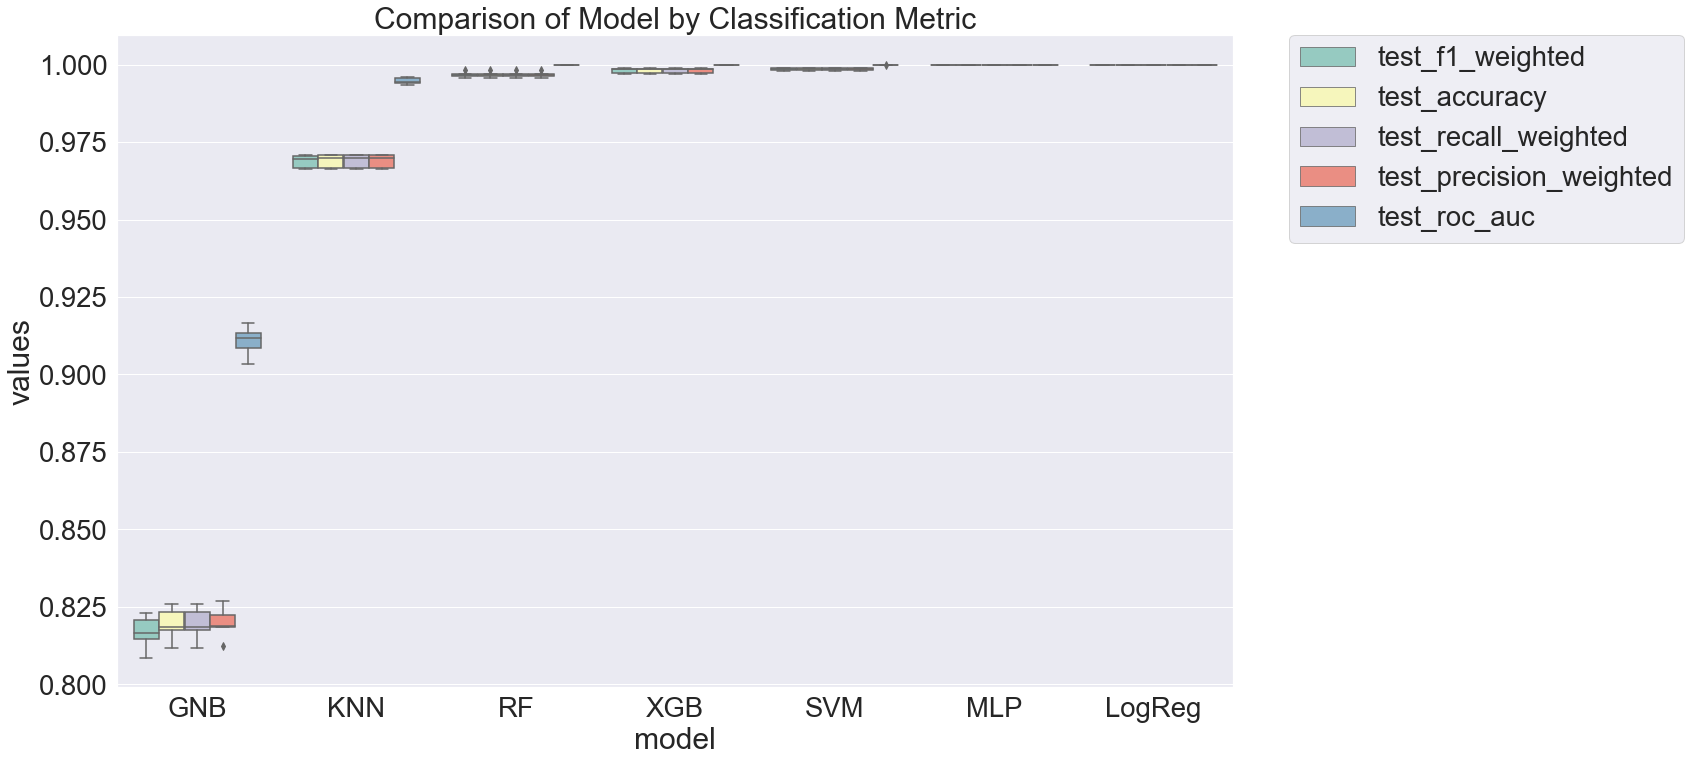

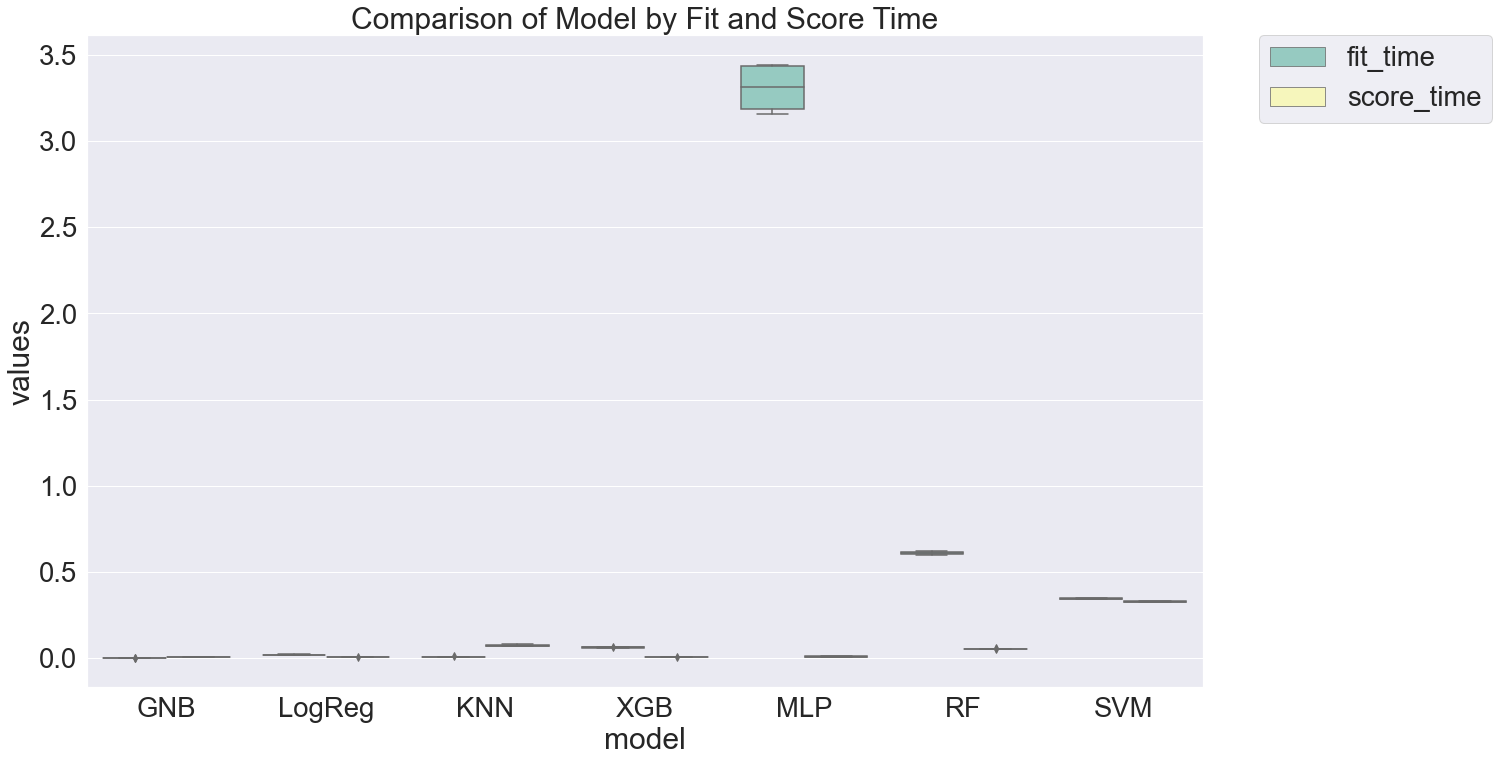

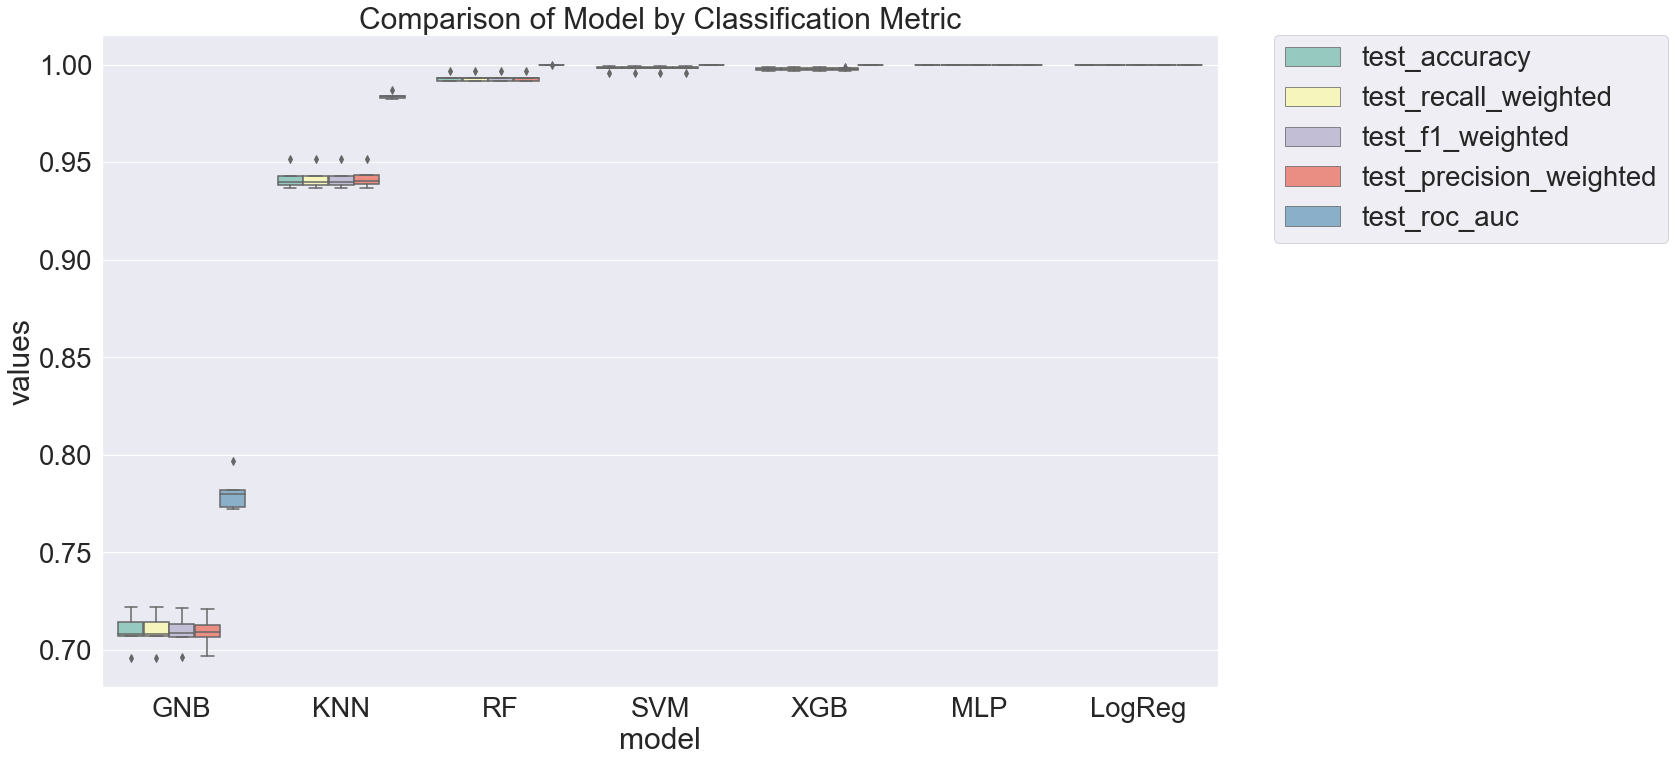

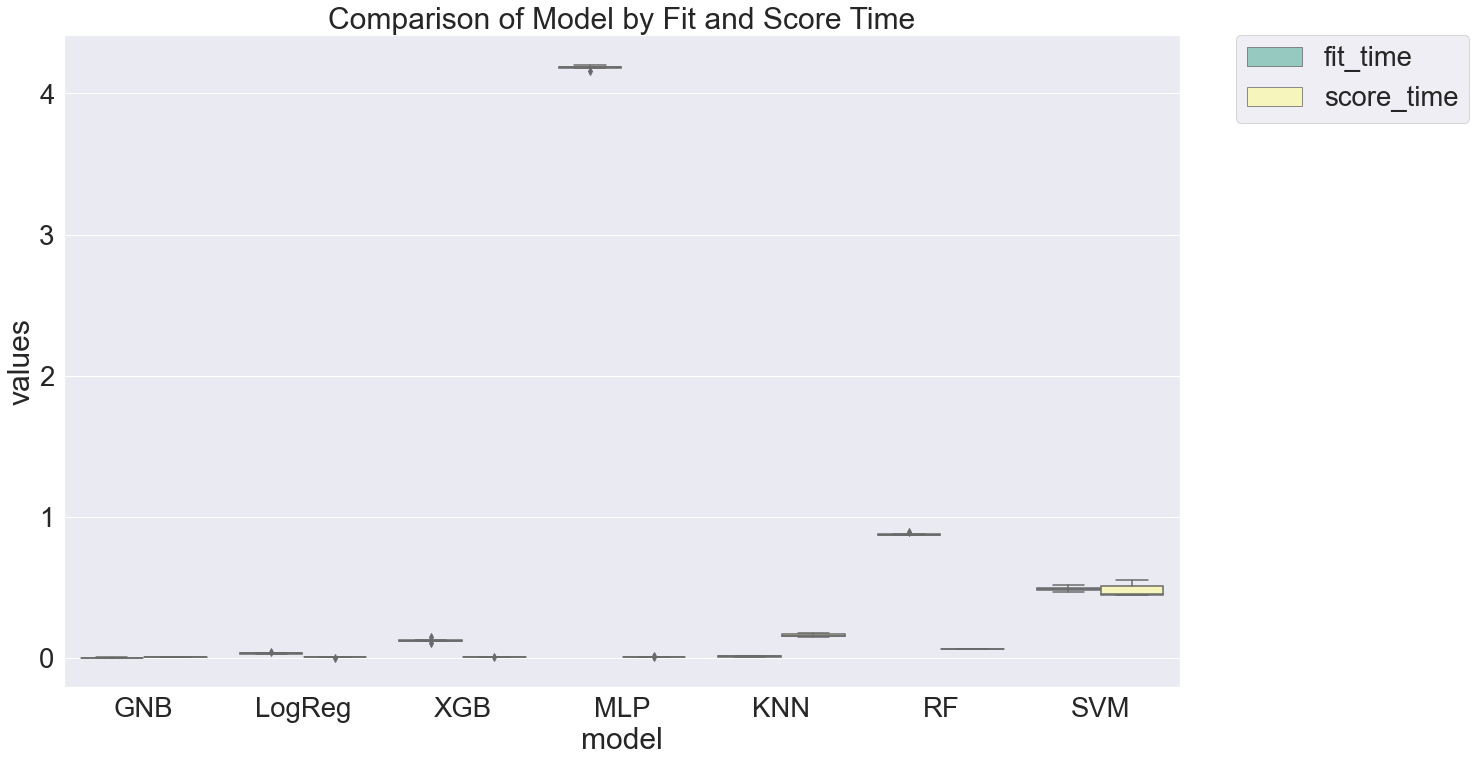

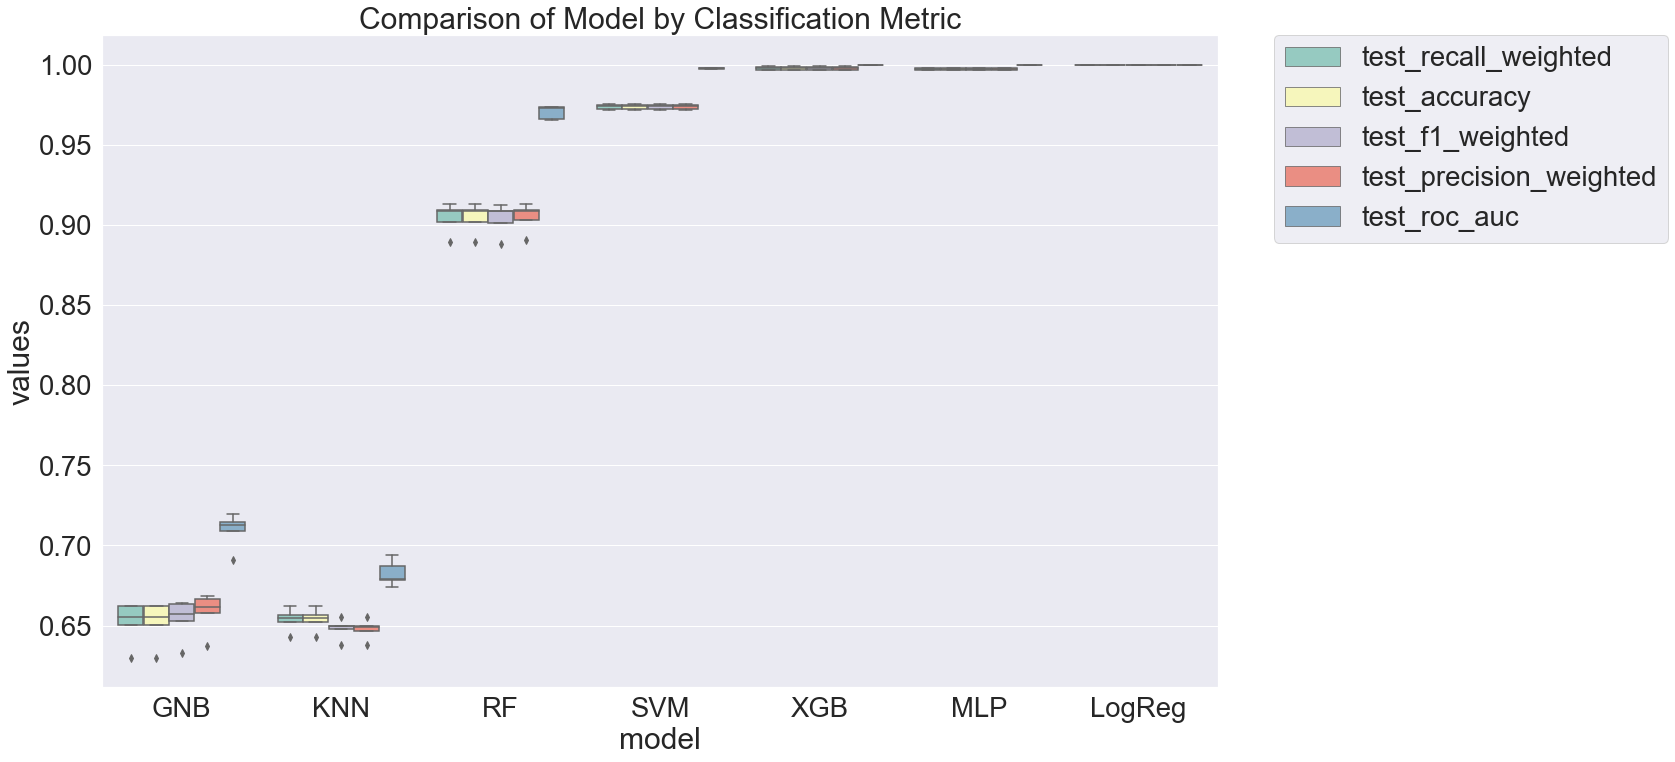

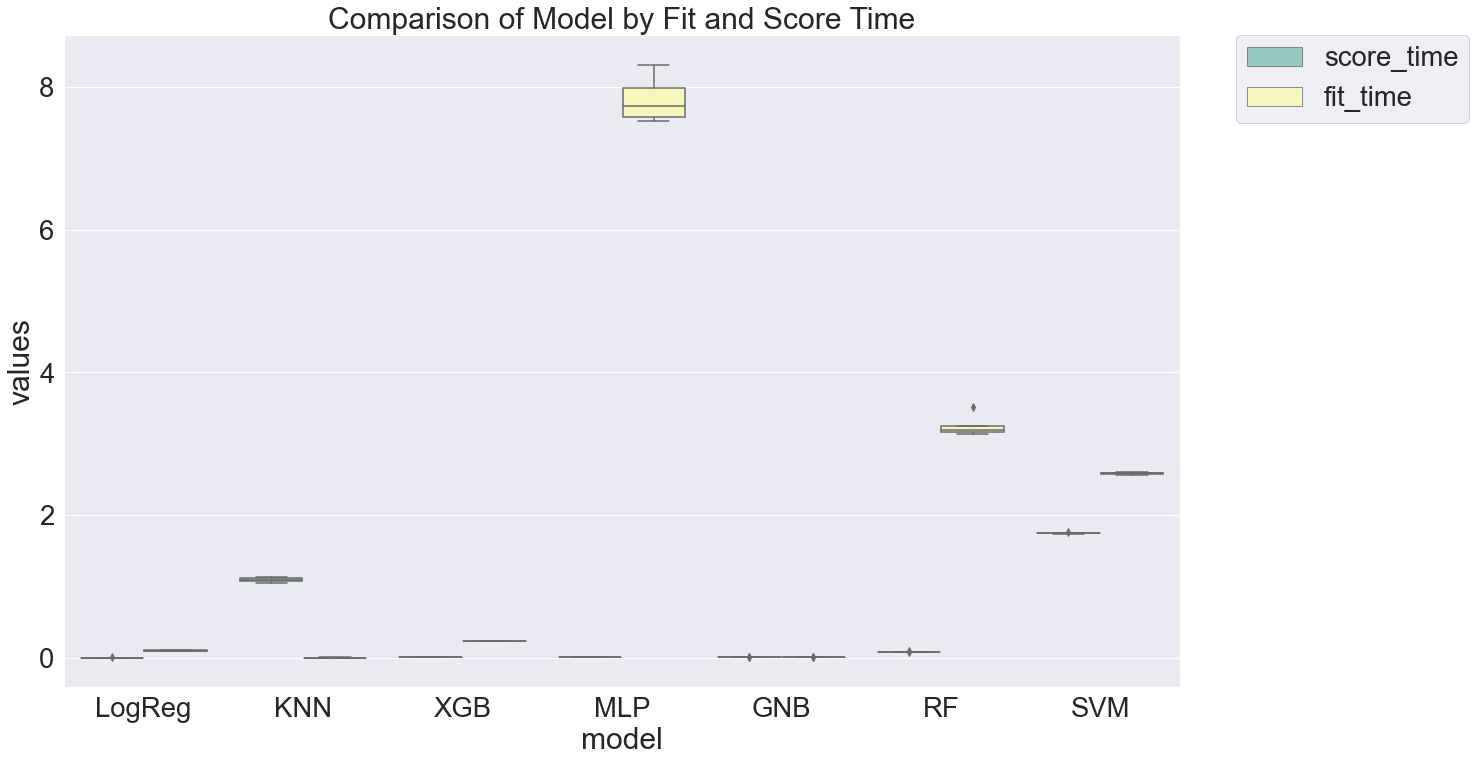

In [51]:
for i,result in enumerate(results):
    results_long_nofit, results_long_fit = evaluate_models(result)
    generate_plots(k[i], results_long_nofit, results_long_fit)

In [ ]:
# from sklearn.metrics import mean_squared_error
# from sklearn.pipeline import make_pipeline

# # Initialize models for regression
# models = {
#     "Logistic Regression": LogisticRegression(),
#     "Random Forest": RandomForestClassifier(),
#     "K-Neighbors": KNeighborsClassifier(),
#     "Support Vector": SVC(),
#     "XGBoost": XGBClassifier(objective='reg:squarederror'),
#     "Gaussian Naive Bayes": GaussianNB(),
#     "Multilayer Perceptron": MLPClassifier(max_iter=1000)
# }

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(f'X train shape: {X_train.shape}')
# print(f'X test shape: {X_test.shape}')

# results = {}

# for name, model in models.items():
#     pipeline = make_pipeline(StandardScaler(), model)
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     results[name] = mse
#     print(f"{name} MSE: {mse:.4f}")

# # Displaying all results
# print("\nModel Mean Squared Errors:")
# for name, mse in results.items():
#     print(f"{name}: {mse:.4f}")